In [470]:
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np

# Define the new size for the images and img_index
new_width = int(3504 * 0.25)
new_height = int(2336 * 0.25)

# Read, resize, and normalize the mask images
image_mask_list = [cv2.resize(cv2.imread(filename, 0), (new_width, new_height)) // 255
                   for filename in sorted(glob.glob('mask/*.tif'))]

# Read, resize the original images, and apply the corresponding mask
image_list = [cv2.resize(cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB), (new_width, new_height)) *
              np.dstack([mask, mask, mask])
              for filename, mask in zip(sorted(glob.glob('images/*.jpg')), image_mask_list)]

# Read and resize the labeled images
image_labeled_list = [cv2.resize(cv2.imread(filename, 1), (new_width, new_height)) 
                      for filename in sorted(glob.glob('manual1/*.tif'))]

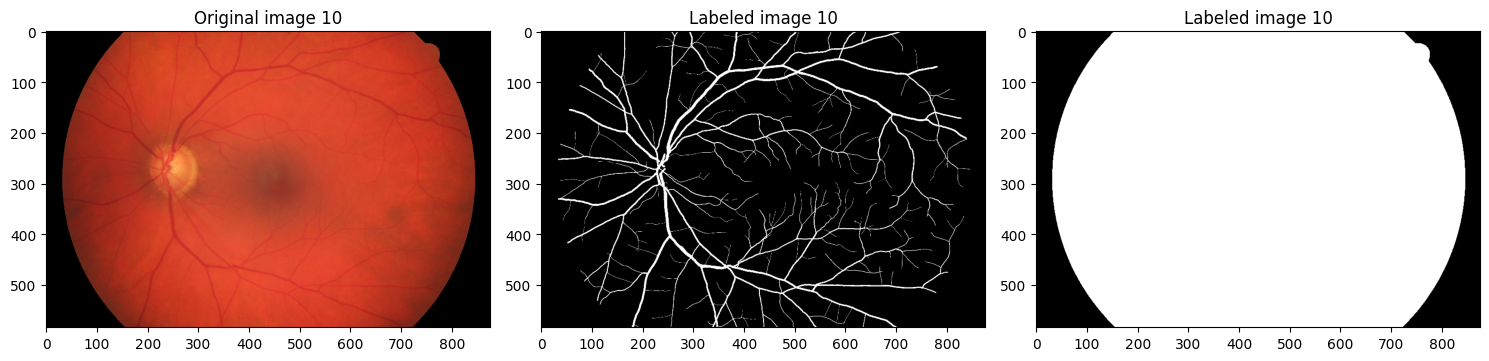

In [471]:
img_index = 10
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("Original image " + str(img_index))
ax1.imshow(image_list[img_index])
# ax1.axis('off')

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("Labeled image " + str(img_index))
ax2.imshow(image_labeled_list[img_index], cmap='gray')
# ax2.axis('off')

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("Labeled image " + str(img_index))
ax3.imshow(image_mask_list[img_index], cmap='gray')
# ax3.axis('off')

plt.tight_layout()
plt.show()

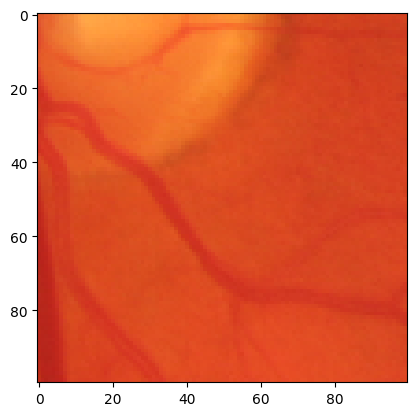

In [472]:
def extract_patches(image, patch_size=5):
    patches = []
    img_height, img_width = image.shape[:2]
    for y in range(0, img_height, patch_size):
        for x in range(0, img_width, patch_size):
            patch = image[y:y+patch_size, x:x+patch_size]
            if patch.shape[:2] == (patch_size, patch_size):
                patches.append((x, y, patch))
    return patches

plt.imshow(extract_patches(image_list[0], 100)[26][2])
plt.show()

In [473]:
from skimage.measure import moments, moments_central, moments_hu

def extract_features(patch):
    features = []
    
    # Color variance for each channel
    for channel in range(patch.shape[2]):
        variance = np.var(patch[:, :, channel])
        features.append(variance)
    
    # Convert to grayscale for moments
    patch_gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)

    # Central moments and Hu moments
    m = moments(patch_gray)

    if m[0, 0] != 0:  # Check to avoid division by zero
        m_central = moments_central(m)
        hu_moments = moments_hu(m_central)
        features.extend(m_central.flatten())
        features.extend(hu_moments)
    else:
        features.extend([0]*23)  # Append zero moments
    
    return features


In [474]:
patch_size = 5
data = []
labels = []

images_to_extract = image_list[:10]
for img, mask in zip(images_to_extract, image_labeled_list):
    patches = extract_patches(img, patch_size)
    for x, y, patch in patches:
        label = mask[y + patch_size // 2, x + patch_size // 2] // 255
        if label.any() == 1:
            features = extract_features(patch)
            data.append(features)
            labels.append(label)
data_len = len(data)

for img, mask in zip(image_list, image_labeled_list):
    patches = extract_patches(img, patch_size)
    for x, y, patch in patches:
        label = mask[y + patch_size // 2, x + patch_size // 2] // 255
        if label.any() == 0:
            features = extract_features(patch)
            if features[0] != 0:
                data.append(features)
                labels.append(label)
        if len(data) >= data_len*2:
            break
    if len(data) >= data_len*2:
            break

data = np.array(data)
labels = np.array(labels)

In [475]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

Accuracy: 0.8770639834881321


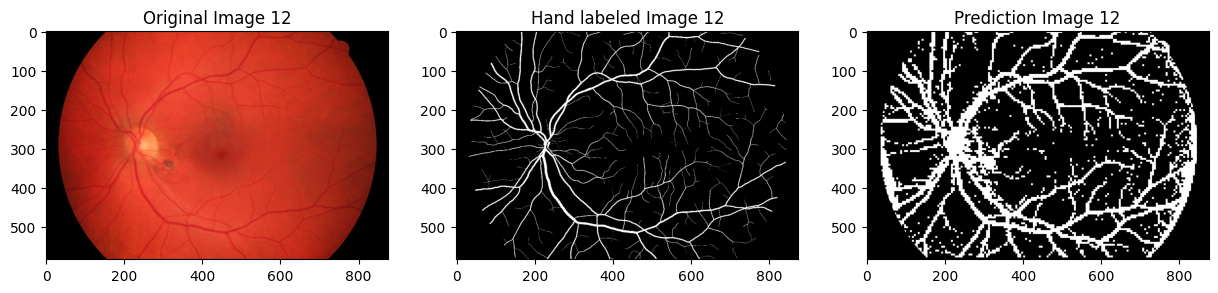

In [479]:
def visualize_predictions(image, clf, patch_size=5):
    img_height, img_width = image.shape[:2]
    prediction_image = np.zeros((img_height, img_width), dtype=np.uint8)
    
    patches = extract_patches(image, patch_size)
    predictions = []
    for x, y, patch in patches:
        features = extract_features(patch)
        prediction = clf.predict([features])
        predictions.append(prediction)
        prediction_image[y:y+patch_size, x:x+patch_size] = prediction[0][0] * 255

    return prediction_image

# Visualize predictions on a test image
test_img_index = 12
test_image = image_list[test_img_index]
prediction_image = visualize_predictions(test_image, clf, 5)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title('Original Image ' + str(test_img_index))

plt.subplot(1, 3, 2)
plt.imshow(image_labeled_list[test_img_index])
plt.title('Hand labeled Image ' + str(test_img_index))

plt.subplot(1, 3, 3)
plt.imshow(prediction_image*image_mask_list[test_img_index], cmap='gray')
plt.title('Prediction Image ' + str(test_img_index))
plt.show()